# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 9.6MB/s 


In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import os
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from IPython.display import clear_output
import kerastuner as kt
from tensorflow_examples.models.pix2pix import pix2pix

## Download

In [ ]:
import json
api_token = {"username": "x", "key": "y"} #
!mkdir -p ~/.kaggle/
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!ls -la /root/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 May 12 17:14 .
drwx------ 1 root root 4096 May 12 17:14 ..
-rw------- 1 root root   73 May 12 17:14 kaggle.json


In [ ]:
!pwd

/content


In [ ]:
path = Path('/content/data')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content/data')

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p {path}

 95% 185M/195M [00:02<00:00, 86.9MB/s]
100% 195M/195M [00:02<00:00, 90.1MB/s]


In [ ]:
!unzip -q -n {path}/breast-ultrasound-images-dataset.zip -d {path}

In [ ]:
!ls '/content/data/Dataset_BUSI_with_GT'

benign	malignant  normal


In [ ]:
path = Path('/content/data/Dataset_BUSI_with_GT')

In [ ]:
os.listdir(f"{path}/benign")

# Load data

In [ ]:
fram_obj_train = {'img' : [], 'mask' : []}

In [ ]:
mask_files = list(sorted(path.rglob('*_mask.png')))
len(mask_files), mask_files[0]

(780,
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png'))

In [ ]:
fram_obj_train['img'] = list(sorted(path.rglob('*[!_mask].png')))
fram_obj_train['mask'] = list(sorted(path.rglob('*_mask.png')))

In [ ]:
def load_data(frame_obj=None, img_path=None, mask_path=None, shape=256):
    img_names = os.listdir(img_path)
    names = []
    mask_names = []
    unames = []
    for i in range(len(img_names)):
        if '_mask_' in img_names[i]: continue
        unames.append(img_names[i].split(')')[0])
    unames = list(set(unames))
    for i in range(len(unames)):
        names.append(f"{unames[i]}).png")
        mask_names.append(f"{unames[i]})_mask.png")
    img_path = f"{img_path}/"
    mask_path = f"{mask_path}/"
    for i in range(len(names)):
        img = plt.imread(img_path + names[i])
        mask = plt.imread(mask_path + mask_names[i])
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frame_obj['img'].append(img)
        frame_obj['mask'].append(mask)
    return frame_obj

In [ ]:
fram_obj_train = load_data(frame_obj=fram_obj_train, img_path=path/f'benign', 
                            mask_path=path/f'benign', shape=256)

In [ ]:
fram_obj_train = load_data(frame_obj=fram_obj_train, img_path=path/f'malignant', 
                            mask_path=path/f'malignant', shape=256)

In [ ]:
fram_obj_train = load_data(frame_obj=fram_obj_train, img_path=path/f'normal', 
                            mask_path=path/f'normal', shape=256)

In [ ]:
len(fram_obj_train['img']), len(fram_obj_train['mask'])

# Explore data

In [ ]:
fram_obj_train['img'][1].name, fram_obj_train['mask'][1].name

In [ ]:
fram_obj_train['img'][1].shape, fram_obj_train['mask'][1].shape

((256, 256, 3), (256, 256))

In [ ]:
np.unique(fram_obj_train['mask'][1])

array([0.0000000e+00, 8.0871582e-04, 3.6468506e-03, 3.9062500e-03,
       4.6234131e-03, 8.9263916e-03, 1.1215210e-02, 2.2109985e-02,
       2.8762817e-02, 3.6087036e-02, 3.6758423e-02, 4.2968750e-02,
       4.4906616e-02, 4.5394897e-02, 5.0888062e-02, 5.1040649e-02,
       7.1517944e-02, 8.9126587e-02, 9.2514038e-02, 9.7656250e-02,
       1.0322571e-01, 1.0546875e-01, 1.0990906e-01, 1.2109375e-01,
       1.3404846e-01, 1.6227722e-01, 1.6670227e-01, 1.6796875e-01,
       1.7820740e-01, 1.8359375e-01, 1.8605042e-01, 1.9047546e-01,
       1.9065857e-01, 1.9148254e-01, 1.9921875e-01, 2.0008850e-01,
       2.0703125e-01, 2.2251892e-01, 2.2618103e-01, 2.3130798e-01,
       2.3268127e-01, 2.4897766e-01, 2.4998474e-01, 2.7626038e-01,
       2.8515625e-01, 2.9344177e-01, 2.9829407e-01, 3.0078125e-01,
       3.1640625e-01, 3.3203125e-01, 3.3290100e-01, 3.4059143e-01,
       3.5420227e-01, 3.5780334e-01, 3.6415100e-01, 3.6579895e-01,
       3.7696838e-01, 3.7890625e-01, 3.8671875e-01, 3.9482117e

In [ ]:
len(fram_obj_train['img']), len(fram_obj_train['mask'])

(780, 780)

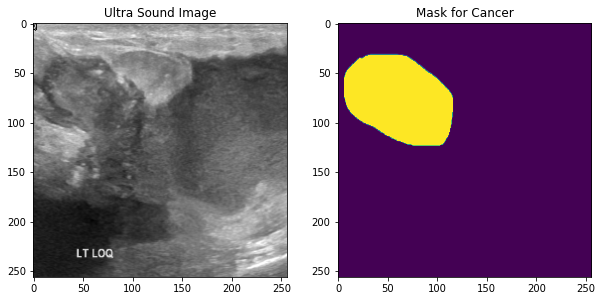

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(fram_obj_train['img'][1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(fram_obj_train['mask'][1])
plt.title('Mask for Cancer')
plt.show()

In [ ]:
torch.unique(fram_obj_train['mask'][1])

# Prepare Model

In [ ]:
def Conv2dBlock(inputTensor, num_filters, kernel_size=3, batch_norm=True):
    # first Conv
    x = tf.keras.layers.Conv2D(filters=num_filters, 
        kernel_size=(kernel_size, kernel_size),
        kernel_initializer='he_normal', padding='same', 
        input_shape=inputTensor) (inputTensor) #, input_shape=inputTensor[1:]
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    # second Conv
    x = tf.keras.layers.Conv2D(filters=num_filters, 
        kernel_size=(kernel_size, kernel_size),
        kernel_initializer='he_normal', padding='same')(x)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def build_unet(input_image, num_filters=16, dropouts=0.1, batch_norm=True):
    c1 = Conv2dBlock(input_image, num_filters * 1, kernel_size=3, batch_norm=batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropouts)(p1)

    c2 = Conv2dBlock(p1, num_filters * 2, kernel_size=3, batch_norm=batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropouts)(p2)

    c3 = Conv2dBlock(p2, num_filters * 4, kernel_size=3, batch_norm=batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropouts)(p3)

    c4 = Conv2dBlock(p3, num_filters * 8, kernel_size=3, batch_norm=batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropouts)(p4)

    c5 = Conv2dBlock(p4, num_filters * 16, kernel_size=3, batch_norm=batch_norm)

    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3,3), strides=(2,2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropouts)(u6)
    c6 = Conv2dBlock(u6, num_filters * 8, kernel_size=3, batch_norm=batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3,3), strides=(2,2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropouts)(u7)
    c7 = Conv2dBlock(u7, num_filters * 4, kernel_size=3, batch_norm=batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3,3), strides=(2,2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropouts)(u8)
    c8 = Conv2dBlock(u8, num_filters * 2, kernel_size=3, batch_norm=batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters * 1, (3,3), strides=(2,2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropouts)(u9)
    c9 = Conv2dBlock(u9, num_filters * 1, kernel_size=3, batch_norm=batch_norm)

    output = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[input_image], outputs=[output])
    return model

# Compile Model

In [ ]:
# learning rate 0.1
optimizer = tf.keras.optimizers.Adam(0.01)

In [ ]:
# inputs = tf.keras.layers.Input(shape=(256, 256, 3))
inputs = tf.keras.layers.Input(shape=(256, 256, 3), batch_size=32)
model = build_unet(inputs, dropouts=0.07)
model.compile(
    # optimizer='Adam', 
    optimizer=optimizer,
    # loss=tf.keras.losses.CategoricalCrossentropy(), 
    # loss='categorical_crossentropy',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(32, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (32, 256, 256, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (32, 256, 256, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (32, 256, 256, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Split

In [ ]:
# len(fram_obj_train['img']) * 0.1235 / 32
split = 32 * 20

In [ ]:
x_train = fram_obj_train['img'][:split]
y_train = fram_obj_train['mask'][:split]
x_val = fram_obj_train['img'][split:]
y_val = fram_obj_train['mask'][split:]

# Train

In [ ]:
history = model.fit(np.array(x_train), np.array(y_train), epochs=10, verbose=1,)

Epoch 1/10
20/20 [==============================] - 45s 359ms/step - loss: 137.4321 - accuracy: 0.5393
Epoch 2/10
20/20 [==============================] - 7s 362ms/step - loss: 122.0729 - accuracy: 0.6863
Epoch 3/10
20/20 [==============================] - 7s 363ms/step - loss: 119.6230 - accuracy: 0.7618
Epoch 4/10
20/20 [==============================] - 7s 366ms/step - loss: 121.5770 - accuracy: 0.8175
Epoch 5/10
20/20 [==============================] - 7s 368ms/step - loss: 124.7633 - accuracy: 0.8280
Epoch 6/10
20/20 [==============================] - 7s 371ms/step - loss: 123.0097 - accuracy: 0.8627
Epoch 7/10
20/20 [==============================] - 7s 372ms/step - loss: 130.8935 - accuracy: 0.8719
Epoch 8/10
20/20 [==============================] - 7s 374ms/step - loss: 124.1474 - accuracy: 0.9036
Epoch 9/10
20/20 [==============================] - 8s 380ms/step - loss: 118.7322 - accuracy: 0.8971
Epoch 10/10
20/20 [==============================] - 8s 383ms/step - loss: 122.05

In [ ]:
history = model.fit(np.array(x_train), np.array(y_train), epochs=10, verbose=1,)

Epoch 1/10
20/20 [==============================] - 9s 357ms/step - loss: 131.0905 - accuracy: 0.7035
Epoch 2/10
20/20 [==============================] - 7s 358ms/step - loss: 124.3280 - accuracy: 0.6766
Epoch 3/10
20/20 [==============================] - 7s 363ms/step - loss: 118.0156 - accuracy: 0.6901
Epoch 4/10
20/20 [==============================] - 7s 362ms/step - loss: 120.5051 - accuracy: 0.6782
Epoch 5/10
20/20 [==============================] - 7s 362ms/step - loss: 120.1970 - accuracy: 0.6941
Epoch 6/10
20/20 [==============================] - 7s 365ms/step - loss: 116.1013 - accuracy: 0.7032
Epoch 7/10
20/20 [==============================] - 7s 368ms/step - loss: 118.4206 - accuracy: 0.7297
Epoch 8/10
20/20 [==============================] - 7s 367ms/step - loss: 116.5217 - accuracy: 0.7219
Epoch 9/10
20/20 [==============================] - 7s 367ms/step - loss: 122.3029 - accuracy: 0.7589
Epoch 10/10
20/20 [==============================] - 7s 370ms/step - loss: 116.532

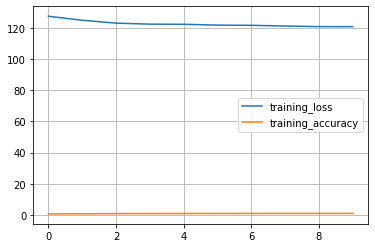

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)

Text(0.5, 1.0, 'accuracy')

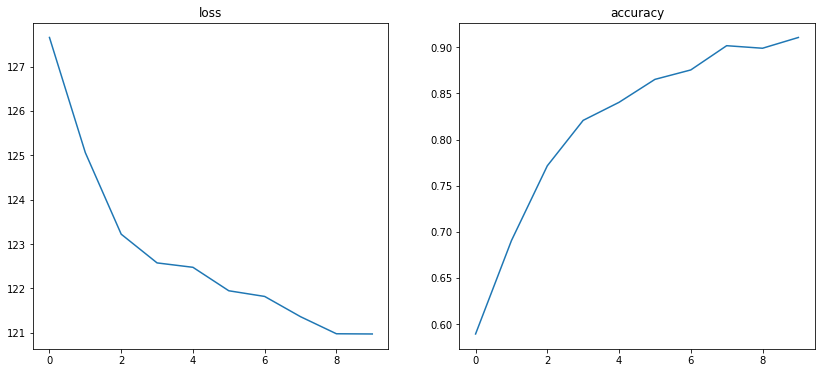

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.title('loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.title('accuracy')

# Testing

In [ ]:
def predict16(valid_m, model, shape=256):
  img = valid_m['img'][0:32]
  mask = valid_m['mask'][0:32]
  img_proc = img[0:32]
  img_proc = np.array(img)
  preds = model.predict(img_proc)
  return preds, img_proc, mask

def Plotter(img, pred_mask, ground_through):
  plt.figure(figsize=(9,9))
  plt.subplot(1,3,1)
  plt.imshow(img)
  plt.title(' image')
  plt.subplot(1,3,2)
  plt.imshow(pred_mask)
  plt.title('Predicted mask')
  plt.subplot(1,3,3)
  plt.imshow(ground_through)
  plt.title('Actual mask')

In [ ]:
predictions, actuals, masks = predict16(fram_obj_train, model)

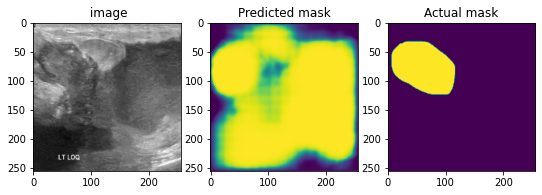

In [ ]:
Plotter(actuals[1], predictions[1][:,:,0], masks[1])

# Hyperparameter tuner

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 128x128
    'block_3_expand_relu',   # 64x64
    'block_6_expand_relu',   # 32x32
    'block_13_expand_relu',  # 16x16
    'block_16_project',      # 8x8
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def u(
    input_size=(256, 256, 3),
    start_neurons=64,
    net_depth=4,
    output_classes=1,
    dropout=False,
    bn_after_act=False,
    activation='mish',
    pretrained_weights=None,
    output_channels=3
):
  inputs = tf.keras.layers.Input(shape=list(input_size))

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def model_builder(hp):    
    start_neurons = hp.Int(name = 'start_neurons', 
                           min_value = 16, 
                           max_value = 128, 
                           step = 16)
    net_depth = hp.Int(name = 'net_depth', min_value = 2, max_value = 6)
    dropout = hp.Boolean(name = 'dropout', default = False)
    bn_after_act = hp.Boolean(name = 'bn_after_act', default = False)
    activation = hp.Choice(name = 'activation', 
                           values = ['mish', 'elu', 'lrelu'], 
                           ordered = False)
    
    input_size = (256,256,3)
    target_labels = [str(i) for i in range(2)]

    model = u(input_size = input_size,
              start_neurons = start_neurons,
              net_depth = net_depth,
              output_classes = len(target_labels),
              dropout = dropout,
              bn_after_act = bn_after_act,
              activation = activation)
  
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3),
                  # loss = weighted_cross_entropy,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = [f1, precision, recall, iou])
    
    return model

In [ ]:
tuner = kt.Hyperband(hypermodel = model_builder,
                     objective = kt.Objective("val_f1", direction="max"),
                     max_epochs = 20,
					 project_name='hyperband_tuner')

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-7ddc325ba563>", line 32, in model_builder
    metrics = [f1, precision, recall, iou])
NameError: name 'f1' is not defined


Invalid model 0/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-7ddc325ba563>", line 32, in model_builder
    metrics = [f1, precision, recall, iou])
NameError: name 'f1' is not defined


Invalid model 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-7ddc325ba563>", line 32, in model_builder
    metrics = [f1, precision, recall, iou])
NameError: name 'f1' is not defined


Invalid model 2/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-7ddc325ba563>", line 32, in model_builder
    metrics = [f1, precision, recall, iou])
NameError: name 'f1' is not defined


Invalid model 3/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-7ddc325ba563>", line 32, in model_builder
    metrics = [f1, precision, recall, iou])
NameError: name 'f1' is not defined


Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/kerastuner/engine/hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-42-7ddc325ba563>", line 32, in model_builder
    metrics = [f1, precision, recall, iou])
NameError: name 'f1' is not defined


RuntimeError: ignored